# Training and Evaluation

In [1]:
# system imports
import os
from datetime import datetime

# additional imports
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.tensorboard import SummaryWriter

# internal imports
from utils import plot_confusion_matrix

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/rodolfolobocarrasco/Library/Caches/pypoetry/virtualenvs/clear-J92jq7Lm-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [2]:
hparams = {    
    'dataset': 'data/prepared_data_balanced.csv',
    'epochs': 15,
    'batch_size': 16,
    'lr': 1e-3,
    'features': [
        'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate',
        'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 
        'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20'
    ]
}

## Prepare Data

In [3]:
df_features = pd.read_csv(hparams['dataset'])

X = np.array(df_features[hparams['features']], dtype=np.float32)

encoder = LabelEncoder()
y = encoder.fit_transform(df_features['label'])
print('classes:', encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)

# create pytorch dataloader
torch.manual_seed(42)
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=hparams['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=hparams['batch_size'], shuffle=False)

classes: ['covid' 'not_covid']
X_train.shape: (107, 26)
y_train.shape: (107,)


## Setup Model

In [4]:
# Design model (input, output size, forward pass)
class CoughNet(torch.nn.Module):
    def __init__(self, input_size):
        super(CoughNet, self).__init__()
        self.l1 = torch.nn.Linear(input_size, 512)
        self.l2 = torch.nn.Linear(512, 256)
        self.l3 = torch.nn.Linear(256, 128)
        self.l4 = torch.nn.Linear(128, 64)
        self.l5 = torch.nn.Linear(64, 10)
        self.l6 = torch.nn.Linear(10, 2)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = torch.relu(self.l3(x))
        x = torch.relu(self.l4(x))
        x = torch.relu(self.l5(x))
        x = self.l6(x)
        return x

model = CoughNet(len(hparams['features'])).to(device)
#model = CoughNet(len(hparams['features'])).to(device).float()

## Training

In [3]:
hparams['lr']

0.001

In [5]:
# Construct loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])
criterion = torch.nn.CrossEntropyLoss()

def train(loader_train, model, optimizer, epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    pbar = tqdm(enumerate(loader_train), total=len(loader_train))
    for batch_ndx, sample in pbar: 
        features, labels = sample[0].to(device), sample[1].to(device) 

        # forward pass and loss calculation
        outputs = model(features)
        loss = criterion(outputs, labels)  
        
        # backward pass    
        loss.backward()
        
        # update weights
        optimizer.step()
        optimizer.zero_grad()
        
        # calculate metrics
        running_loss += loss.item()
        predictions = torch.argmax(outputs.data, 1)
        running_correct += (predictions == labels).sum().item()

        # print informations
        pbar.set_description(f'[Training Epoch {epoch+1}]') 
        total += labels.shape[0]
        pbar.set_postfix({'loss': running_loss / total, 'train_accuracy': running_correct / total})
        
    # write informations to tensorboard
    writer.add_scalar('Loss/Train', running_loss / total, epoch+1)
    writer.add_scalar('Accuracy/Train', running_correct / total, epoch+1)

def evaluate(loader_test, model, epoch):
    model.eval()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(loader_test), total=len(loader_test))
        for batch_ndx, sample in pbar:
            features, labels = sample[0].to(device), sample[1].to(device) 

            # forward pass and loss calculation
            outputs = model(features)
            loss = criterion(outputs, labels)  

            # calculate metrics
            running_loss += loss.item()
            predictions = torch.argmax(outputs.data, 1)
            running_correct += (predictions == labels).sum().item()

            # print informations
            pbar.set_description(f'[Evaluating Epoch {epoch+1}]')
            total += labels.shape[0]
            pbar.set_postfix({'loss': running_loss / total, 'eval_accuracy': running_correct / total})
        
    # write informations to tensorboard
    writer.add_scalar('Loss/Eval', running_loss / total, epoch+1)
    writer.add_scalar('Accuracy/Eval', running_correct / total, epoch+1)

# initialize tensorboard summary writer
time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
writer = SummaryWriter(f'logs/{time_stamp}/')

# add graph to tensorboard
features = iter(test_loader).__next__()[0]
writer.add_graph(model, features)

# training loop
for epoch in range(hparams['epochs']):
    train(train_loader, model, optimizer, epoch)
    evaluate(test_loader, model, epoch)

# close tensorboard
writer.close()

# open tensorboard
# tensorboard --logdir logs

[Evaluating Epoch 15]: 100%|██████████| 2/2 [00:00<00:00, 798.46it/s, loss=0.0409, eval_accuracy=0.852]


## Plot confusion matrix

In [8]:
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

[0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1]


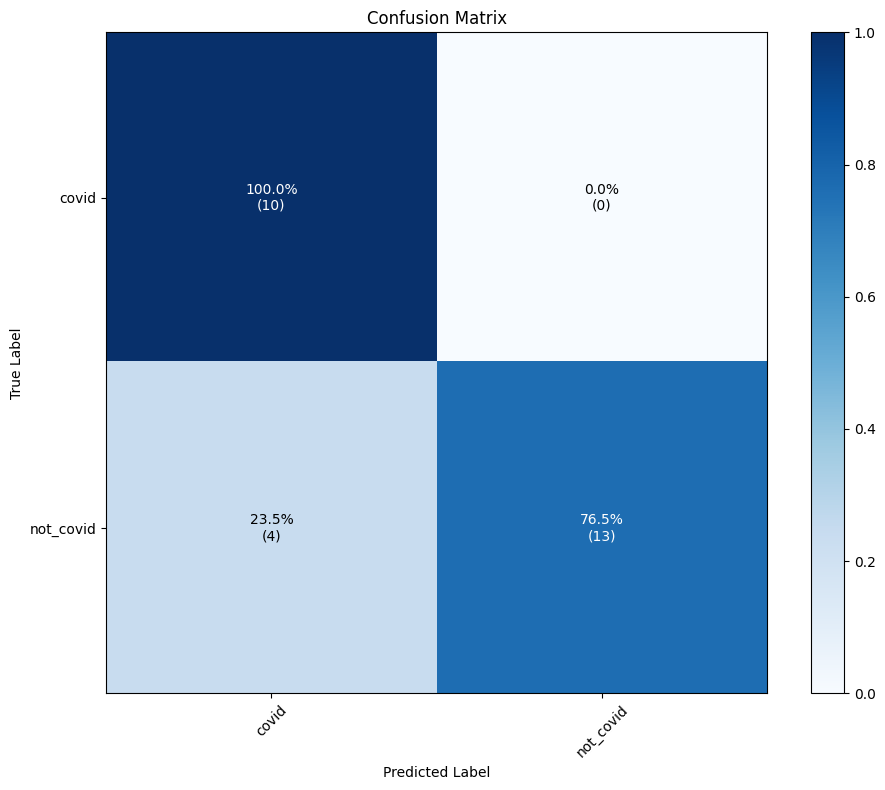

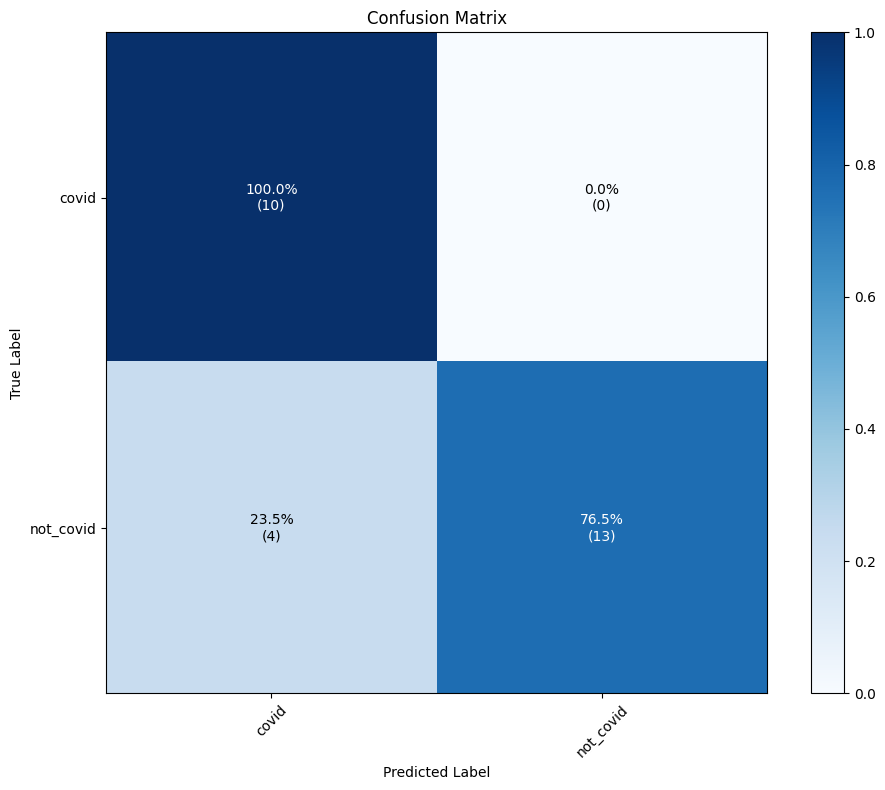

In [17]:
model.eval()
with torch.no_grad():
    test_tensor = torch.Tensor(X_test).to(device)  # This will be float32 by default
    outputs = model(test_tensor)
    predictions = torch.argmax(outputs.data, 1).cpu()  # Add .cpu() if predictions needed for plotting


# Then modify the plot_confusion_matrix function in utils.py:
def plot_confusion_matrix(targets, predictions, classes):
    # calculate confusion matrix
    cm = confusion_matrix(targets, predictions)
    
    # calculate percentages
    cm_percent = cm.astype(np.float64) / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels to each cell
    thresh = cm_percent.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Format as percentage
            plt.text(j, i, f'{cm_percent[i, j]:.1%}\n({cm[i, j]})',
                    ha="center", va="center",
                    color="white" if cm_percent[i, j] > thresh else "black")
    
    # Add labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Now you can call it:
# Make sure both are numpy arrays before plotting
y_test_np = y_test if isinstance(y_test, np.ndarray) else y_test.numpy()
print(y_test_np)
plot_confusion_matrix(y_test_np, predictions, encoder.classes_)

plot_confusion_matrix(y_test_np, predictions, encoder.classes_)

## Save checkpoint after training

In [18]:
checkpoint = {
    'hparams': hparams,
    'model_state': model.state_dict(),
    'scaler': scaler,
    'encoder': encoder
}
torch.save(checkpoint, 'checkpoints/checkpoint.pth')